In [ ]:
"""This code reads an Excel file containing MR imaging data, 
groups the data by the 'Group' column, 
and calculates the mean and variance for several imaging parameters, 
including scan duration, time, TE, TR, 
bandwidth, slice thickness, and the number of slices. 
The resulting statistics are printed and saved to a new Excel file."
"""
import pandas as pd

# Read the Excel file (replace 'your_excel_file.xlsx' with your actual file name)
df = pd.read_excel('/Users/ziling/Desktop/MRCP/data_excel/temp.xlsx')

# Group by 'Group' and calculate the mean and variance for the relevant columns
stats = df.groupby('Group').agg(
    scandurati_mean=('scanduration', 'mean'),
    scandurati_var=('scanduration', 'var'),
    time_mean=('time', 'mean'),
    time_var=('time', 'var'),
    TE_mean=('TE', 'mean'),
    TE_var=('TE', 'var'),
    TR_mean=('TR', 'mean'),
    TR_var=('TR', 'var'),
    Bandwidth_mean=('Bandwidth', 'mean'),
    Bandwidth_var=('Bandwidth', 'var'),
    slice_thickness_mean=('slice_thickness', 'mean'),
    slice_thickness_var=('slice_thickness', 'var'),
    num_slices_mean=('num_slices', 'mean'),
    num_slices_var=('num_slices', 'var')
)

# Output the result
print(stats)

# If you want to save the result to an Excel file
stats.to_excel('/Users/ziling/Desktop/MRCP/data_excel/grouped_stats_output.xlsx')

In [ ]:
import pandas as pd

# Define a function to load the Excel file, calculate the median and IQR range, and save the results
def process_data(file_path, output_dir):
    # Load the Excel file
    df = pd.read_excel(file_path)
    
    # Define a function to calculate IQR range as a string
    def iqr_range(x):
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        return f"{q1:.2f} - {q3:.2f}"  # Formatting the range as a string

    # Group by both 'Group' and 'Radius' and calculate the median and IQR range for each metric
    grouped_stats = df.groupby(['Group', 'Radius']).agg(
        SNR_median=('SNR', 'median'),
        SNR_IQR=('SNR', iqr_range),
        Contrast_median=('Contrast', 'median'),
        Contrast_IQR=('Contrast', iqr_range),
        CNR_median=('CNR', 'median'),
        CNR_IQR=('CNR', iqr_range),
        FWHM_median=('FWHM', 'median'),
        FWHM_IQR=('FWHM', iqr_range)
    ).reset_index()

    # Extract unique Radius values
    unique_radii = df['Radius'].unique()

    # Save results for each Radius group
    for radius in unique_radii:
        # Filter for the specific radius
        radius_stats = grouped_stats[grouped_stats['Radius'] == radius]
        
        # Construct the output file path based on the radius
        output_path = f"{output_dir}/MRCP_LocData_stats_{radius}.csv"
        
        # Save the results to a CSV file
        radius_stats.to_csv(output_path, index=False)
        
        # Display the results
        print(f"Results for Radius {radius}:")
        print(radius_stats)
        print("\n")

# File paths for 6-voxel and 12-voxel data
file_paths = [
    ('/Users/ziling/Desktop/MRCP/results/MRCP_LocData.xlsx', 
     '/Users/ziling/Desktop/MRCP/results/')
]

# Process both files
for file_path, output_dir in file_paths:
    process_data(file_path, output_dir)

In [16]:
import pandas as pd
from scipy.stats import kruskal, mannwhitneyu

# Define a function to load the Excel file, calculate median and IQR, and return the results
def process_data(file_path, group_name):
    # Load the Excel file
    df = pd.read_excel(file_path)
    
    # Convert 'Radius' to string for consistent querying
    df['Radius'] = df['Radius'].astype(str)
    
    # Define a function to calculate IQR range as a string
    def median_iqr(x):
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        return f"{x.median():.2f} ({q1:.2f} - {q3:.2f})"

    # Group by 'Radius' and calculate the median and IQR for each metric
    grouped_stats = df.groupby('Radius').agg(
        SNR_median_iqr=('SNR', median_iqr),
        Contrast_median_iqr=('Contrast', median_iqr),
        CNR_median_iqr=('CNR', median_iqr),
        FWHM_median_iqr=('FWHM', median_iqr)
    ).reset_index()
    
    # Add group name to the DataFrame
    grouped_stats['Group'] = group_name
    
    return grouped_stats

# File paths and group names
file_info = [
    ('/Users/ziling/Desktop/MRCP/results/MRCP_Radiopaedia.xlsx', 'MRCP_Radiopaedia'),
    ('/Users/ziling/Desktop/MRCP/results/MRCP_CPTAC.xlsx', 'MRCP_CPTAC'),
    ('/Users/ziling/Desktop/MRCP/results/MRCP_LocData.xlsx', 'MRCP_LocData')
]

# Collect the results for all groups
all_data = pd.DataFrame()
for file_path, group_name in file_info:
    data = process_data(file_path, group_name)
    all_data = pd.concat([all_data, data], ignore_index=True)

# Save the combined median and IQR results to an Excel file
output_file = '/Users/ziling/Desktop/MRCP/results/Combined_Median_IQR_Results.xlsx'
all_data.to_excel(output_file, index=False)
print(f"Combined median and IQR results saved to {output_file}")

# Statistical comparisons
all_p_values = {}

# Define pairwise comparisons
pairs = [('MRCP_Radiopaedia', 'MRCP_CPTAC'), ('MRCP_Radiopaedia', 'MRCP_LocData'), ('MRCP_CPTAC', 'MRCP_LocData')]

# Perform Kruskal-Wallis and pairwise Mann-Whitney U tests for each radius and metric
for radius in all_data['Radius'].unique():
    radius_str = str(radius)  # Ensure radius is in string format for querying
    p_values_overall = {}
    p_values_pairwise = []

    # Filter data for the current radius
    radius_data = {group_name: pd.read_excel(file_path) for file_path, group_name in file_info}
    
    # Ensure 'Radius' is treated as string for matching
    for group_name, data in radius_data.items():
        data['Radius'] = data['Radius'].astype(str)
        radius_data[group_name] = data.query(f"Radius == '{radius_str}'")

    # Debugging: Check for empty data
    print(f"\nAnalyzing Radius: {radius}")
    for group_name, data in radius_data.items():
        print(f"{group_name} data count for {radius}: {len(data)}")
        if data.empty:
            print(f"Warning: No data found for Radius {radius} in {group_name}")

    for metric in ['SNR', 'Contrast', 'CNR', 'FWHM']:
        # Prepare data for the overall Kruskal-Wallis test
        groups = [data[metric].dropna() for data in radius_data.values() if not data[metric].dropna().empty]
        if len(groups) < 2:  # Skip if there are fewer than two groups with data
            print(f"Insufficient data for overall comparison on {metric} at Radius {radius}")
            continue
        
        # Kruskal-Wallis test for overall differences
        stat, p = kruskal(*groups)
        p_values_overall[metric] = p

        # Pairwise Mann-Whitney U tests
        for group1, group2 in pairs:
            data1 = radius_data[group1][metric].dropna()
            data2 = radius_data[group2][metric].dropna()
            
            if not data1.empty and not data2.empty:
                stat, p_pairwise = mannwhitneyu(data1, data2, alternative='two-sided')
                p_values_pairwise.append({'Metric': metric, 'Group1': group1, 'Group2': group2, 'P-Value': p_pairwise})
            else:
                print(f"Insufficient data for pairwise comparison on {metric} between {group1} and {group2} at Radius {radius}")

    # Save results for each radius
    all_p_values[radius] = {
        'overall': pd.DataFrame(list(p_values_overall.items()), columns=['Metric', 'Overall P-Value']),
        'pairwise': pd.DataFrame(p_values_pairwise)
    }

# Save all P-values to an Excel file
with pd.ExcelWriter('/Users/ziling/Desktop/MRCP/results/P_Values_Comparison_by_Radius.xlsx') as writer:
    for radius, p_values in all_p_values.items():
        # Clean sheet name
        radius_cleaned = str(radius).replace('[', '').replace(']', '')
        p_values['overall'].to_excel(writer, sheet_name=f'Overall_{radius_cleaned}', index=False)
        p_values['pairwise'].to_excel(writer, sheet_name=f'Pairwise_{radius_cleaned}', index=False)

print("P-values for overall and pairwise comparisons saved by radius to P_Values_Comparison_by_Radius.xlsx")

Combined median and IQR results saved to /Users/ziling/Desktop/MRCP/results/Combined_Median_IQR_Results.xlsx

Analyzing Radius: [12, 12, 12]
MRCP_Radiopaedia data count for [12, 12, 12]: 30
MRCP_CPTAC data count for [12, 12, 12]: 8
MRCP_LocData data count for [12, 12, 12]: 1240

Analyzing Radius: [6, 6, 6]
MRCP_Radiopaedia data count for [6, 6, 6]: 30
MRCP_CPTAC data count for [6, 6, 6]: 8
MRCP_LocData data count for [6, 6, 6]: 1240
P-values for overall and pairwise comparisons saved by radius to P_Values_Comparison_by_Radius.xlsx


In [ ]:
import pandas as pd
from scipy.stats import shapiro
import numpy as np

# Define a function to test for normality using the Shapiro-Wilk test
def check_normality(df, columns, group, radius, transform=None):
    normality_results = []
    
    for column in columns:
        # Apply log transformation if specified, avoiding log(0)
        data = np.log(df[column].replace(0, np.nan)).dropna() if transform == 'log' else df[column].dropna()
        
        # Perform the Shapiro-Wilk test
        stat, p_value = shapiro(data)
        normality_results.append({
            'Group': group,
            'Radius': radius,
            'Metric': column,
            'Transform': transform if transform else 'None',
            'Statistic': stat,
            'p-value': p_value,
            'Distribution': 'Normally distributed' if p_value > 0.05 else 'Not normally distributed'
        })
        
        # Print the results
        print(f"{column} ({'log-transformed' if transform == 'log' else 'original'}) for Group: {group}, Radius: {radius}: "
              f"Data is {'normally distributed' if p_value > 0.05 else 'NOT normally distributed'} (p = {p_value:.3f})")
    
    return normality_results

# Define a reusable function to load data, perform normality tests by Group and Radius, and display results
def process_normality_tests(file_path, columns_to_check):
    # Load the Excel file
    df = pd.read_excel(file_path)
    
    # Ensure 'Group' and 'Radius' columns are present
    if 'Group' not in df.columns or 'Radius' not in df.columns:
        raise KeyError("The dataset must contain 'Group' and 'Radius' columns.")
    
    all_results = []
    
    # Group the data by 'Group' and 'Radius' and perform the tests
    grouped_df = df.groupby(['Group', 'Radius'])
    
    for (group, radius), group_data in grouped_df:
        print(f"\nNormality test for Group: {group}, Radius: {radius} (Original Data):")
        original_results = check_normality(group_data, columns_to_check, group, radius)
        
        print(f"\nNormality test for Group: {group}, Radius: {radius} (Log-transformed Data):")
        log_results = check_normality(group_data, columns_to_check, group, radius, transform='log')
        
        # Combine results from original and log-transformed data
        all_results.extend(original_results)
        all_results.extend(log_results)
    
    # Convert the results into a DataFrame for better readability
    normality_combined_df = pd.DataFrame(all_results)
    
    # Display the combined results
    print("\nCombined normality test results:")
    print(normality_combined_df)
    
    return normality_combined_df

# List of columns to check for normality
columns_to_check = ["SNR", "Contrast", "CNR", "FWHM"]

# File paths for 6-voxel and 12-voxel data
file_paths = [
    '/Users/ziling/Desktop/MRCP/results/MRCP_LocData.xlsx'
]

# Process both files and perform normality tests by Group and Radius
for file_path in file_paths:
    print(f"\nProcessing file: {file_path}")
    process_normality_tests(file_path, columns_to_check)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from statannot import add_stat_annotation

def perform_friedman_test(df, params, groups):
    friedman_results = {}
    for param in params:
        group_data = [df.loc[df['Group'] == group, param] for group in groups]
        stat, p_value = friedmanchisquare(*group_data)
        friedman_results[param] = (stat, p_value)
    return friedman_results

def perform_posthoc_dunn_test(df, params):
    posthoc_results = {}
    for param in params:
        posthoc_results[param] = sp.posthoc_dunn(df, val_col=param, group_col='Group', p_adjust='bonferroni')
    return posthoc_results

def save_stat_results(file_path, friedman_results, posthoc_results):
    with pd.ExcelWriter(file_path) as writer:
        pd.DataFrame(friedman_results, index=["Test Statistic", "p-value"]).T.to_excel(writer, sheet_name="Friedman_Test")
        for param, posthoc_df in posthoc_results.items():
            posthoc_df.to_excel(writer, sheet_name=f"Posthoc_{param}")

def create_combined_violin_plots(df, params, groups, file_path, pairs):
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(18, 21))  # Adjust the size for 4x2 subplots
    palette = sns.color_palette("Set2")

    # Separate data based on the 'radius' column
    df_12voxels = df[df['Radius'] == '[12, 12, 12]']
    df_6voxels = df[df['Radius'] == '[6, 6, 6]']

    for i, param in enumerate(params, 1):
        plt.subplot(4, 2, i*2-1)  # Subplot for 12-voxel data
        ax = sns.violinplot(x="Group", y=param, data=df_12voxels, palette=palette, inner="box", linewidth=1.2)
        plt.title(f"{param} Across Groups (12 voxels)", fontsize=14, weight='bold')
        plt.xlabel("Group", fontsize=12)
        plt.ylabel(param, fontsize=12)

        add_stat_annotation(ax, data=df_12voxels, x="Group", y=param, box_pairs=pairs, test='Mann-Whitney', 
                            text_format='star', loc='inside', verbose=2, fontsize='small')
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}' if x.is_integer() else f'{x:.1f}'))

        plt.subplot(4, 2, i*2)  # Subplot for 6-voxel data
        ax = sns.violinplot(x="Group", y=param, data=df_6voxels, palette=palette, inner="box", linewidth=1.2)
        plt.title(f"{param} Across Groups (6 voxels)", fontsize=14, weight='bold')
        plt.xlabel("Group", fontsize=12)
        plt.ylabel(param, fontsize=12)

        add_stat_annotation(ax, data=df_6voxels, x="Group", y=param, box_pairs=pairs, test='Mann-Whitney', 
                            text_format='star', loc='inside', verbose=2, fontsize='small')
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}' if x.is_integer() else f'{x:.1f}'))

    plt.tight_layout(pad=4.5)
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.savefig(file_path)
    plt.show()

def main_with_radius(file_path, output_dir, params, groups, pairs):
    df = pd.read_excel(file_path)

    # Step 1: Perform Friedman Test for both 12-voxel and 6-voxel data based on 'radius'
    df_12voxels = df[df['Radius'] == '[12, 12, 12]']
    df_6voxels = df[df['Radius'] == '[6, 6, 6]']

    friedman_results12 = perform_friedman_test(df_12voxels, params, groups)
    posthoc_results12 = perform_posthoc_dunn_test(df_12voxels, params)

    friedman_results6 = perform_friedman_test(df_6voxels, params, groups)
    posthoc_results6 = perform_posthoc_dunn_test(df_6voxels, params)

    # Step 2: Save statistical results for both 12-voxel and 6-voxel data
    save_stat_results(f'{output_dir}/Statistical_Results_LocData_12voxels.xlsx', friedman_results12, posthoc_results12)
    save_stat_results(f'{output_dir}/Statistical_Results_LocData_6voxels.xlsx', friedman_results6, posthoc_results6)

    # Step 3: Create and save combined violin plots for both 12-voxel and 6-voxel data
    create_combined_violin_plots(df, params, groups, f'{output_dir}/Combined_Violin_Plots.pdf', pairs)

    # Step 4: Print results
    print(f"Friedman Test Results (12 voxels):", friedman_results12)
    print(f"Friedman Test Results (6 voxels):", friedman_results6)
    print("\nPost-hoc Dunn Test Results (12 voxels):")
    for param, result in posthoc_results12.items():
        print(f"\n{param} Pairwise Comparisons:\n{result}")
    print("\nPost-hoc Dunn Test Results (6 voxels):")
    for param, result in posthoc_results6.items():
        print(f"\n{param} Pairwise Comparisons:\n{result}")

# Define common parameters and groups
params = ["SNR", "Contrast", "CNR", "FWHM"]
groups = ["RTr0", "RTr1", "BH0", "BH1"]
pairs = [("RTr0", "RTr1"), ("RTr0", "BH0"), ("RTr0", "BH1"), ("RTr1", "BH0"), ("RTr1", "BH1"), ("BH0", "BH1")]

# Process data with 'radius' column for both 12-voxel and 6-voxel groups
main_with_radius('/Users/ziling/Desktop/MRCP/results/MRCP_LocData.xlsx', 
                 '/Users/ziling/Desktop/MRCP/results', 
                 params, 
                 groups, 
                 pairs)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

RTr0 v.s. RTr1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.059e+04
RTr1 v.s. BH0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.414e-08 U_stat=3.506e+04
BH0 v.s. BH1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.810e+04
RTr0 v.s. BH0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.122e-05 U_stat=3.742e+04
RTr1 v.s. BH1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.572e-08 U_stat=3.495e+04
RTr0 v.s. BH1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.055e-05 U_stat=3.739e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00

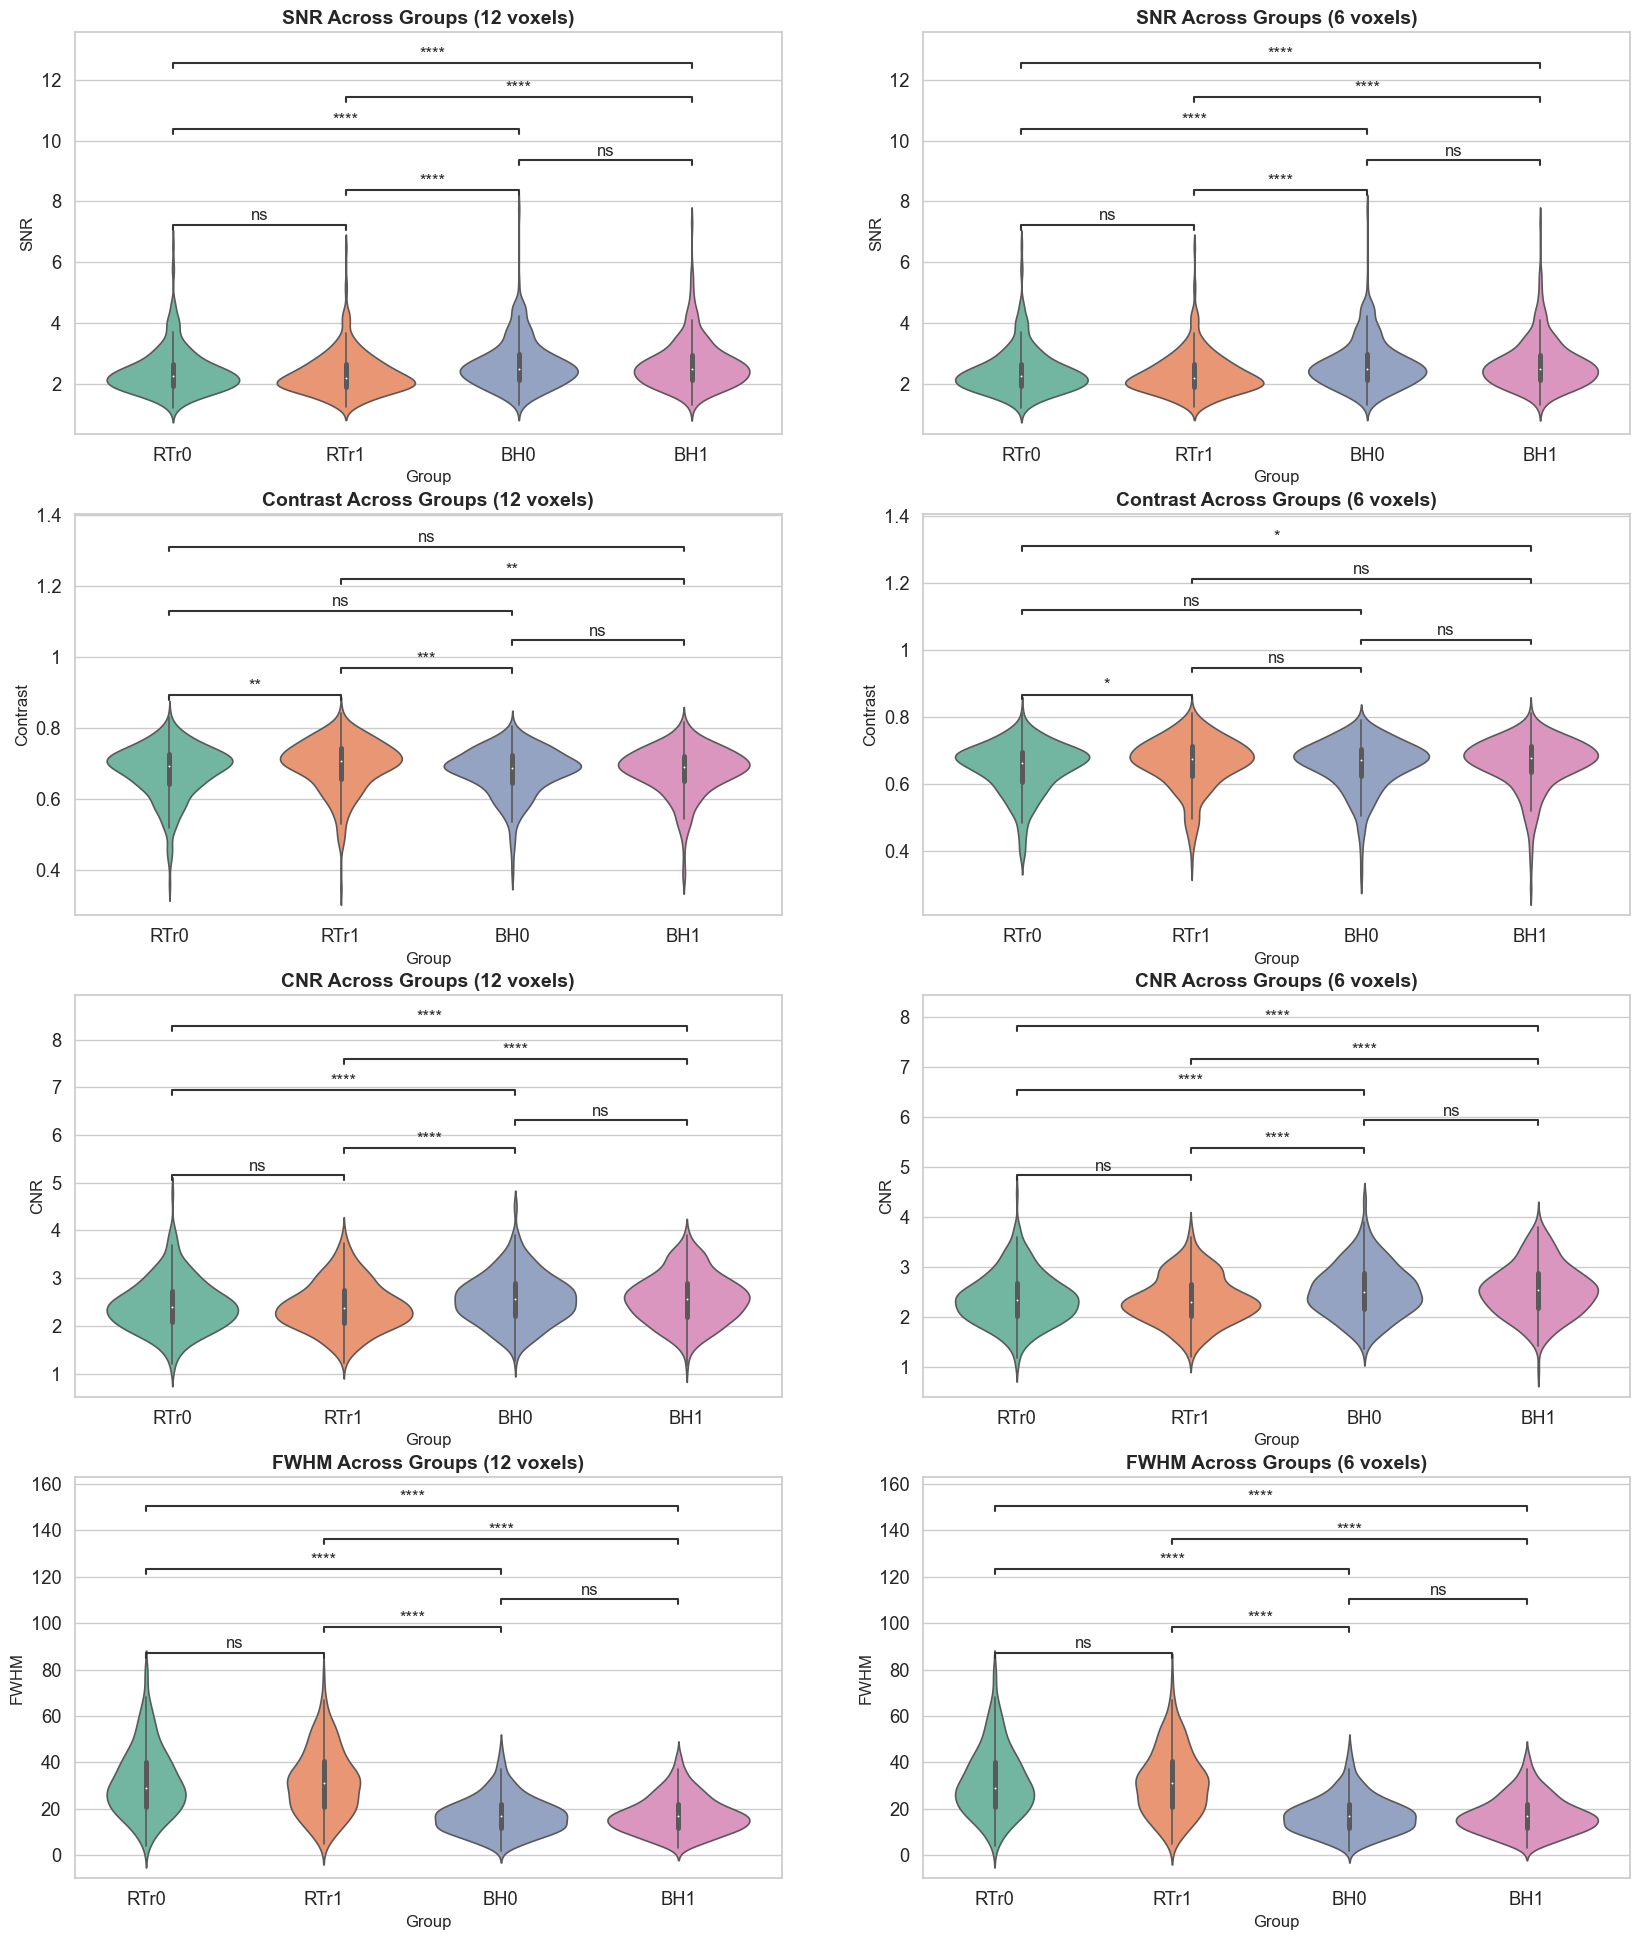

Friedman Test Results (12 voxels): {'SNR': (251.60406582768655, 2.943649589132029e-54), 'Contrast': (78.07066795740535, 7.958176400916401e-17), 'FWHM': (619.075868983957, 7.377257431993773e-134)}
Friedman Test Results (6 voxels): {'SNR': (251.60406582768655, 2.943649589132029e-54), 'Contrast': (48.320425943853266, 1.8200459303859733e-10), 'FWHM': (619.075868983957, 7.377257431993773e-134)}

Paired T-test Results (12 voxels): {'RTr0 vs RTr1': (0.8159109119929286, 0.41517959135612215), 'RTr0 vs BH0': (-7.715736236379235, 1.6732448843441145e-13), 'RTr0 vs BH1': (-7.125097574357352, 7.361989294634825e-12), 'RTr1 vs BH0': (-8.009540172934294, 2.3689775182259923e-14), 'RTr1 vs BH1': (-8.429839179961187, 1.3362330617216722e-15), 'BH0 vs BH1': (-0.1767113507860121, 0.8598508900399788)}

Paired T-test Results (6 voxels): {'RTr0 vs RTr1': (1.0558967497749914, 0.2918402329313559), 'RTr0 vs BH0': (-8.965652992268105, 3.015473008186229e-17), 'RTr0 vs BH1': (-8.029426932142494, 2.0719086536445966e-1

In [41]:
from scipy.stats import ttest_rel
import numpy as np

def perform_paired_t_test(df, groups):
    ttest_results = {}
    for group1, group2 in pairs:
        group1_data = np.log(df.loc[df['Group'] == group1, 'CNR'])
        group2_data = np.log(df.loc[df['Group'] == group2, 'CNR'])
        stat, p_value = ttest_rel(group1_data, group2_data)
        ttest_results[f"{group1} vs {group2}"] = (stat, p_value)
    return ttest_results

def perform_friedman_test(df, params, groups):
    friedman_results = {}
    for param in params:
        if param == 'CNR':  # Skip the CNR since it's log-transformed and handled by paired t-test
            continue
        group_data = [df.loc[df['Group'] == group, param] for group in groups]
        stat, p_value = friedmanchisquare(*group_data)
        friedman_results[param] = (stat, p_value)
    return friedman_results

def perform_posthoc_dunn_test(df, params):
    posthoc_results = {}
    for param in params:
        if param == 'CNR':  # Skip CNR as it's handled by paired t-test
            continue
        posthoc_results[param] = sp.posthoc_dunn(df, val_col=param, group_col='Group', p_adjust='bonferroni')
    return posthoc_results

def save_stat_results(file_path, friedman_results, posthoc_results, ttest_results):
    with pd.ExcelWriter(file_path) as writer:
        pd.DataFrame(friedman_results, index=["Test Statistic", "p-value"]).T.to_excel(writer, sheet_name="Friedman_Test")
        pd.DataFrame(ttest_results, index=["Test Statistic", "p-value"]).T.to_excel(writer, sheet_name="Paired_T_Test")
        for param, posthoc_df in posthoc_results.items():
            posthoc_df.to_excel(writer, sheet_name=f"Posthoc_{param}")

def create_combined_violin_plots(df, params, groups, file_path, pairs):
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(18, 21))  # Adjust the size for 4x2 subplots
    palette = sns.color_palette("Set2")

    # Separate data based on the 'radius' column
    df_12voxels = df[df['Radius'] == '[12, 12, 12]']
    df_6voxels = df[df['Radius'] == '[6, 6, 6]']

    for i, param in enumerate(params, 1):
        plt.subplot(4, 2, i*2-1)  # Subplot for 12-voxel data
        ax = sns.violinplot(x="Group", y=param, data=df_12voxels, palette=palette, inner="box", linewidth=1.2)
        plt.title(f"{param} Across Groups (12 voxels)", fontsize=14, weight='bold')
        plt.xlabel("Group", fontsize=12)
        plt.ylabel(param, fontsize=12)

        # Skip the Mann-Whitney test for CNR, use paired t-test annotations instead
        if param == 'CNR':
            add_stat_annotation(ax, data=df_12voxels, x="Group", y=param, box_pairs=pairs, test='t-test_paired', 
                                text_format='star', loc='inside', verbose=2, fontsize='small')
        else:
            add_stat_annotation(ax, data=df_12voxels, x="Group", y=param, box_pairs=pairs, test='Mann-Whitney', 
                                text_format='star', loc='inside', verbose=2, fontsize='small')

        ax.get_yaxis().get_major_formatter().set_scientific(False)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}' if x.is_integer() else f'{x:.1f}'))

        plt.subplot(4, 2, i*2)  # Subplot for 6-voxel data
        ax = sns.violinplot(x="Group", y=param, data=df_6voxels, palette=palette, inner="box", linewidth=1.2)
        plt.title(f"{param} Across Groups (6 voxels)", fontsize=14, weight='bold')
        plt.xlabel("Group", fontsize=12)
        plt.ylabel(param, fontsize=12)

        # Skip the Mann-Whitney test for CNR, use paired t-test annotations instead
        if param == 'CNR':
            add_stat_annotation(ax, data=df_6voxels, x="Group", y=param, box_pairs=pairs, test='t-test_paired', 
                                text_format='star', loc='inside', verbose=2, fontsize='small')
        else:
            add_stat_annotation(ax, data=df_6voxels, x="Group", y=param, box_pairs=pairs, test='Mann-Whitney', 
                                text_format='star', loc='inside', verbose=2, fontsize='small')

        ax.get_yaxis().get_major_formatter().set_scientific(False)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}' if x.is_integer() else f'{x:.1f}'))

    plt.tight_layout(pad=4.5)
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.savefig(file_path)
    plt.show()

def main_with_radius(file_path, output_dir, params, groups, pairs):
    df = pd.read_excel(file_path)

    # Step 1: Perform Friedman Test for non-CNR parameters
    df_12voxels = df[df['Radius'] == '[12, 12, 12]']
    df_6voxels = df[df['Radius'] == '[6, 6, 6]']

    friedman_results12 = perform_friedman_test(df_12voxels, params, groups)
    posthoc_results12 = perform_posthoc_dunn_test(df_12voxels, params)

    friedman_results6 = perform_friedman_test(df_6voxels, params, groups)
    posthoc_results6 = perform_posthoc_dunn_test(df_6voxels, params)

    # Step 2: Perform Paired T-test for log-transformed CNR
    ttest_results12 = perform_paired_t_test(df_12voxels, groups)
    ttest_results6 = perform_paired_t_test(df_6voxels, groups)

    # Step 3: Save statistical results for both 12-voxel and 6-voxel data
    save_stat_results(f'{output_dir}/Statistical_Results_LocData_12voxels.xlsx', friedman_results12, posthoc_results12, ttest_results12)
    save_stat_results(f'{output_dir}/Statistical_Results_LocData_6voxels.xlsx', friedman_results6, posthoc_results6, ttest_results6)

    # Step 4: Create and save combined violin plots for both 12-voxel and 6-voxel data
    create_combined_violin_plots(df, params, groups, f'{output_dir}/Combined_Violin_Plots.pdf', pairs)

    # Step 5: Print results
    print(f"Friedman Test Results (12 voxels):", friedman_results12)
    print(f"Friedman Test Results (6 voxels):", friedman_results6)
    print("\nPaired T-test Results (12 voxels):", ttest_results12)
    print("\nPaired T-test Results (6 voxels):", ttest_results6)
    print("\nPost-hoc Dunn Test Results (12 voxels):")
    for param, result in posthoc_results12.items():
        print(f"\n{param} Pairwise Comparisons:\n{result}")
    print("\nPost-hoc Dunn Test Results (6 voxels):")
    for param, result in posthoc_results6.items():
        print(f"\n{param} Pairwise Comparisons:\n{result}")

# Define common parameters and groups
params = ["SNR", "Contrast", "CNR", "FWHM"]
groups = ["RTr0", "RTr1", "BH0", "BH1"]
pairs = [("RTr0", "RTr1"), ("RTr0", "BH0"), ("RTr0", "BH1"), ("RTr1", "BH0"), ("RTr1", "BH1"), ("BH0", "BH1")]

# Process data with 'radius' column for both 12-voxel and 6-voxel groups
main_with_radius('/Users/ziling/Desktop/MRCP/results/MRCP_LocData.xlsx', 
                 '/Users/ziling/Desktop/MRCP/results', 
                 params, 
                 groups, 
                 pairs)

In [42]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel

def compare_parameters_across_voxels(df, params, groups):
    comparison_results = {}

    # Log-transform the CNR parameter
    df['log_CNR'] = np.log(df['CNR'])
    
    # Separate data based on 'Radius' (6-voxel and 12-voxel groups)
    df_12voxels = df[df['Radius'] == '[12, 12, 12]']
    df_6voxels = df[df['Radius'] == '[6, 6, 6]']

    # Iterate over parameters (Contrast and log_CNR)
    for param in params:
        param_results = {}
        # Perform paired t-test between 12-voxel and 6-voxel for each group
        for group in groups:
            if param == 'CNR':
                c12 = df_12voxels[df_12voxels['Group'] == group]['log_CNR']
                c6 = df_6voxels[df_6voxels['Group'] == group]['log_CNR']
            else:
                c12 = df_12voxels[df_12voxels['Group'] == group][param]
                c6 = df_6voxels[df_6voxels['Group'] == group][param]
            
            # Paired t-test
            stat, p_value = ttest_rel(c12, c6)
            param_results[group] = {'Test Statistic': stat, 'p-value': p_value}
        
        comparison_results[param] = pd.DataFrame(param_results).T

    return comparison_results

# Define parameters (Contrast and CNR) and groups for comparison
params = ['Contrast', 'CNR']
groups = ["RTr0", "RTr1", "BH0", "BH1"]

# Load the data
df = pd.read_excel('/Users/ziling/Desktop/MRCP/results/MRCP_LocData.xlsx')

# Perform comparison of Contrast and CNR between 6-voxel and 12-voxel
comparison_results = compare_parameters_across_voxels(df, params, groups)

# Output the results
for param, result in comparison_results.items():
    print(f"\nComparison of {param} between 6-voxel and 12-voxel groups:")
    print(result)

    # Optionally, save each result to an Excel file
    result.to_excel(f'/Users/ziling/Desktop/MRCP/results/{param}_Comparison_Voxels.xlsx')


Comparison of Contrast between 6-voxel and 12-voxel groups:
      Test Statistic        p-value
RTr0       31.957350  5.799138e-100
RTr1       31.670919   4.896565e-99
BH0        17.420289   7.980880e-48
BH1        16.208218   3.460904e-43

Comparison of CNR between 6-voxel and 12-voxel groups:
      Test Statistic       p-value
RTr0        9.955685  1.959972e-20
RTr1       11.306177  4.903475e-25
BH0         5.439720  1.086833e-07
BH1         5.115136  5.513314e-07


In [ ]:
"""This code performs statistical analysis and visualization for comparing multiple groups of 
MRI data parameters (SNR, Contrast, CNR, FWHM). Specifically, 
it conducts Friedman Test between groups, 
applies a post-hoc Dunn test for multiple comparisons, 
saves the results to an Excel file, 
and generates violin plots to visually compare the distributions of the parameters across different groups.
 The plots also include pairwise statistical significance annotations."""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from statannot import add_stat_annotation

def perform_analysis_and_plot(file_path, output_pdf, output_excel):
    # Read the Excel file
    df = pd.read_excel(file_path)

    # Modify the 'Radi' column to label it as '6 voxels' and '12 voxels'
    df['Voxels'] = df['Radi'].apply(lambda x: '6 voxels' if '[6, 6, 6]' in x else '12 voxels')

    # Step 1: Perform Friedman Test
    friedman_results = {}
    for param in ["SNR", "Contr", "CNI", "FWHM"]:  # Update column names as per your file
        stat, p_value = friedmanchisquare(df.loc[df['Group'] == 'RTr0', param],
                                          df.loc[df['Group'] == 'RTr1', param],
                                          df.loc[df['Group'] == 'BH0', param],
                                          df.loc[df['Group'] == 'BH1', param])
        friedman_results[param] = (stat, p_value)

    # Step 2: Perform Post-hoc Dunn Test
    posthoc_results = {}
    for param in ["SNR", "Contr", "CNI", "FWHM"]:
        posthoc_results[param] = sp.posthoc_dunn(df, val_col=param, group_col='Group', p_adjust='bonferroni')

    # Save statistical results to Excel
    results_df = pd.DataFrame(friedman_results, index=["Test Statistic", "p-value"]).T
    posthoc_dfs = {param: result for param, result in posthoc_results.items()}

    with pd.ExcelWriter(output_excel) as writer:
        results_df.to_excel(writer, sheet_name="Friedman_Test")
        for param, posthoc_df in posthoc_dfs.items():
            posthoc_df.to_excel(writer, sheet_name=f"Posthoc_{param}")

    # Set up plot style and configuration
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(18, 24))  # Larger figure for better visibility

    palette = sns.color_palette("Set2")
    pairs = [("RTr0", "RTr1"), ("RTr0", "BH0"), ("RTr0", "BH1"),
             ("RTr1", "BH0"), ("RTr1", "BH1"), ("BH0", "BH1")]

    # Create violin plots with p-value annotations
    params = ["SNR", "Contr", "CNI", "FWHM"]
    subplot_idx = 1  # Start index for subplot

    for param in params:
        # Create two subplots for each parameter
        plt.subplot(2, 2, subplot_idx)
        ax = sns.violinplot(x="Group", y=param, data=df, palette=palette, inner="box", linewidth=1.2)
        plt.title(f"{param} Across Groups", fontsize=14, weight='bold')

        plt.xlabel("Group", fontsize=12)
        plt.ylabel(param, fontsize=12)

        # Add pairwise comparisons p-values
        add_stat_annotation(ax, data=df, x="Group", y=param,
                            box_pairs=pairs, test='Mann-Whitney', 
                            text_format='star', loc='inside', verbose=2, fontsize='small')

        # Adjust y-axis formatting for clarity
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}' if x.is_integer() else f'{x:.1f}'))

        plt.tight_layout(pad=4.5)
        subplot_idx += 1  # Move to the next subplot

    # Save and display the plots
    plt.subplots_adjust(hspace=0.4, wspace=0.2)  # Adjust spacing between subplots
    plt.savefig(output_pdf)
    plt.show()

    # Print Friedman test and post-hoc results
    print(f"Friedman Test Results ({file_path}):")
    print(friedman_results)

    print("\nPost-hoc Dunn Test Results:")
    for param, result in posthoc_results.items():
        print(f"\n{param} Pairwise Comparisons:")
        print(result)

# Unified file paths (both 6 voxels and 12 voxels data)
file_path = '/Users/ziling/Desktop/MRCP/results/MRCP_LocData.xlsx'
output_pdf = '/Users/ziling/Desktop/MRCP/results/Violin_Plots_LocData.pdf'
output_excel = '/Users/ziling/Desktop/MRCP/results/Statistical_Results_LocData.xlsx'

# Perform the analysis and plotting
perform_analysis_and_plot(file_path, output_pdf, output_excel)

In [ ]:
"""This code performs statistical analysis and visualization for comparing multiple groups of 
MRI data parameters (SNR, Contrast, CNR, FWHM). Specifically, 
it conducts paired t-tests between groups, 
applies a post-hoc Dunn test for multiple comparisons, 
saves the results to an Excel file, 
and generates violin plots to visually compare the distributions of the parameters across different groups.
 The plots also include pairwise statistical significance annotations."""


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
import scikit_posthocs as sp
from statannot import add_stat_annotation

def perform_analysis_and_plot(file_path, output_pdf, output_excel):
    # Read the Excel file
    df = pd.read_excel(file_path)

    # Modify the 'Radi' column to label it as '6 voxels' and '12 voxels'
    df['Voxels'] = df['Radi'].apply(lambda x: '6 voxels' if '[6, 6, 6]' in x else '12 voxels')

    # Step 1: Perform Paired t-tests
    paired_ttest_results = {}
    for param in ["SNR", "Contr", "CNI", "FWHM"]:
        # Run paired t-tests between each pair of groups
        stat_RTr0_RTr1, p_value_RTr0_RTr1 = ttest_rel(df.loc[df['Group'] == 'RTr0', param], 
                                                      df.loc[df['Group'] == 'RTr1', param])
        stat_RTr0_BH0, p_value_RTr0_BH0 = ttest_rel(df.loc[df['Group'] == 'RTr0', param], 
                                                    df.loc[df['Group'] == 'BH0', param])
        stat_RTr0_BH1, p_value_RTr0_BH1 = ttest_rel(df.loc[df['Group'] == 'RTr0', param], 
                                                    df.loc[df['Group'] == 'BH1', param])
        stat_RTr1_BH0, p_value_RTr1_BH0 = ttest_rel(df.loc[df['Group'] == 'RTr1', param], 
                                                    df.loc[df['Group'] == 'BH0', param])
        stat_RTr1_BH1, p_value_RTr1_BH1 = ttest_rel(df.loc[df['Group'] == 'RTr1', param], 
                                                    df.loc[df['Group'] == 'BH1', param])
        stat_BH0_BH1, p_value_BH0_BH1 = ttest_rel(df.loc[df['Group'] == 'BH0', param], 
                                                  df.loc[df['Group'] == 'BH1', param])

        # Store the results in a dictionary
        paired_ttest_results[param] = {
            "RTr0_vs_RTr1": (stat_RTr0_RTr1, p_value_RTr0_RTr1),
            "RTr0_vs_BH0": (stat_RTr0_BH0, p_value_RTr0_BH0),
            "RTr0_vs_BH1": (stat_RTr0_BH1, p_value_RTr0_BH1),
            "RTr1_vs_BH0": (stat_RTr1_BH0, p_value_RTr1_BH0),
            "RTr1_vs_BH1": (stat_RTr1_BH1, p_value_RTr1_BH1),
            "BH0_vs_BH1": (stat_BH0_BH1, p_value_BH0_BH1)
        }

    # Step 2: Perform Post-hoc Dunn Test (if needed)
    posthoc_results = {}
    for param in ["SNR", "Contr", "CNI", "FWHM"]:
        posthoc_results[param] = sp.posthoc_dunn(df, val_col=param, group_col='Group', p_adjust='bonferroni')

    # Save statistical results to Excel
    results_df = pd.DataFrame(paired_ttest_results).T
    posthoc_dfs = {param: result for param, result in posthoc_results.items()}

    with pd.ExcelWriter(output_excel) as writer:
        results_df.to_excel(writer, sheet_name="Paired_ttest_Results")
        for param, posthoc_df in posthoc_dfs.items():
            posthoc_df.to_excel(writer, sheet_name=f"Posthoc_{param}")

    # Set up plot style and configuration
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(18, 24))  # Larger figure for better visibility

    palette = sns.color_palette("Set2")
    pairs = [("RTr0", "RTr1"), ("RTr0", "BH0"), ("RTr0", "BH1"),
             ("RTr1", "BH0"), ("RTr1", "BH1"), ("BH0", "BH1")]

    # Create violin plots with p-value annotations
    params = ["SNR", "Contr", "CNI", "FWHM"]
    subplot_idx = 1  # Start index for subplot

    for param in params:
        plt.subplot(2, 2, subplot_idx)
        ax = sns.violinplot(x="Group", y=param, data=df, palette=palette, inner="box", linewidth=1.2)
        plt.title(f"{param} Across Groups", fontsize=14, weight='bold')

        plt.xlabel("Group", fontsize=12)
        plt.ylabel(param, fontsize=12)

        # Add pairwise comparisons p-values
        add_stat_annotation(ax, data=df, x="Group", y=param,
                            box_pairs=pairs, test='Mann-Whitney', 
                            text_format='star', loc='inside', verbose=2, fontsize='small')

        # Adjust y-axis formatting for clarity
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}' if x.is_integer() else f'{x:.1f}'))

        plt.tight_layout(pad=4.5)
        subplot_idx += 1  # Move to the next subplot

    # Save and display the plots
    plt.subplots_adjust(hspace=0.4, wspace=0.2)  # Adjust spacing between subplots
    plt.savefig(output_pdf)
    plt.show()

    # Print paired t-test and post-hoc results
    print(f"Paired t-test Results ({file_path}):")
    print(paired_ttest_results)

    print("\nPost-hoc Dunn Test Results:")
    for param, result in posthoc_results.items():
        print(f"\n{param} Pairwise Comparisons:")
        print(result)

# File paths for unified 6 voxels and 12 voxels data
file_path = '/Users/ziling/Desktop/MRCP/results/MRCP_LocData.xlsx'
output_pdf = '/Users/ziling/Desktop/MRCP/results/Violin_Plots_LocData.pdf'
output_excel = '/Users/ziling/Desktop/MRCP/results/Statistical_Results_LocData.xlsx'

# Perform the analysis and plotting
perform_analysis_and_plot(file_path, output_pdf, output_excel)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LocData v.s. Radiopaedia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.038e-04 U_stat=1.038e+04
Radiopaedia v.s. CPTAC-PDA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.361e-01 U_stat=1.760e+02
LocData v.s. CPTAC-PDA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.450e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LocData v.s. Radiopaedia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.038e-04 U_stat=1.038e+04
Radiopaedia v.s. CPTAC-PDA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.361e-01 U_stat=1.760e+02
LocData v.s. CPTAC-PDA: Mann-Whitney-Wilcoxon test

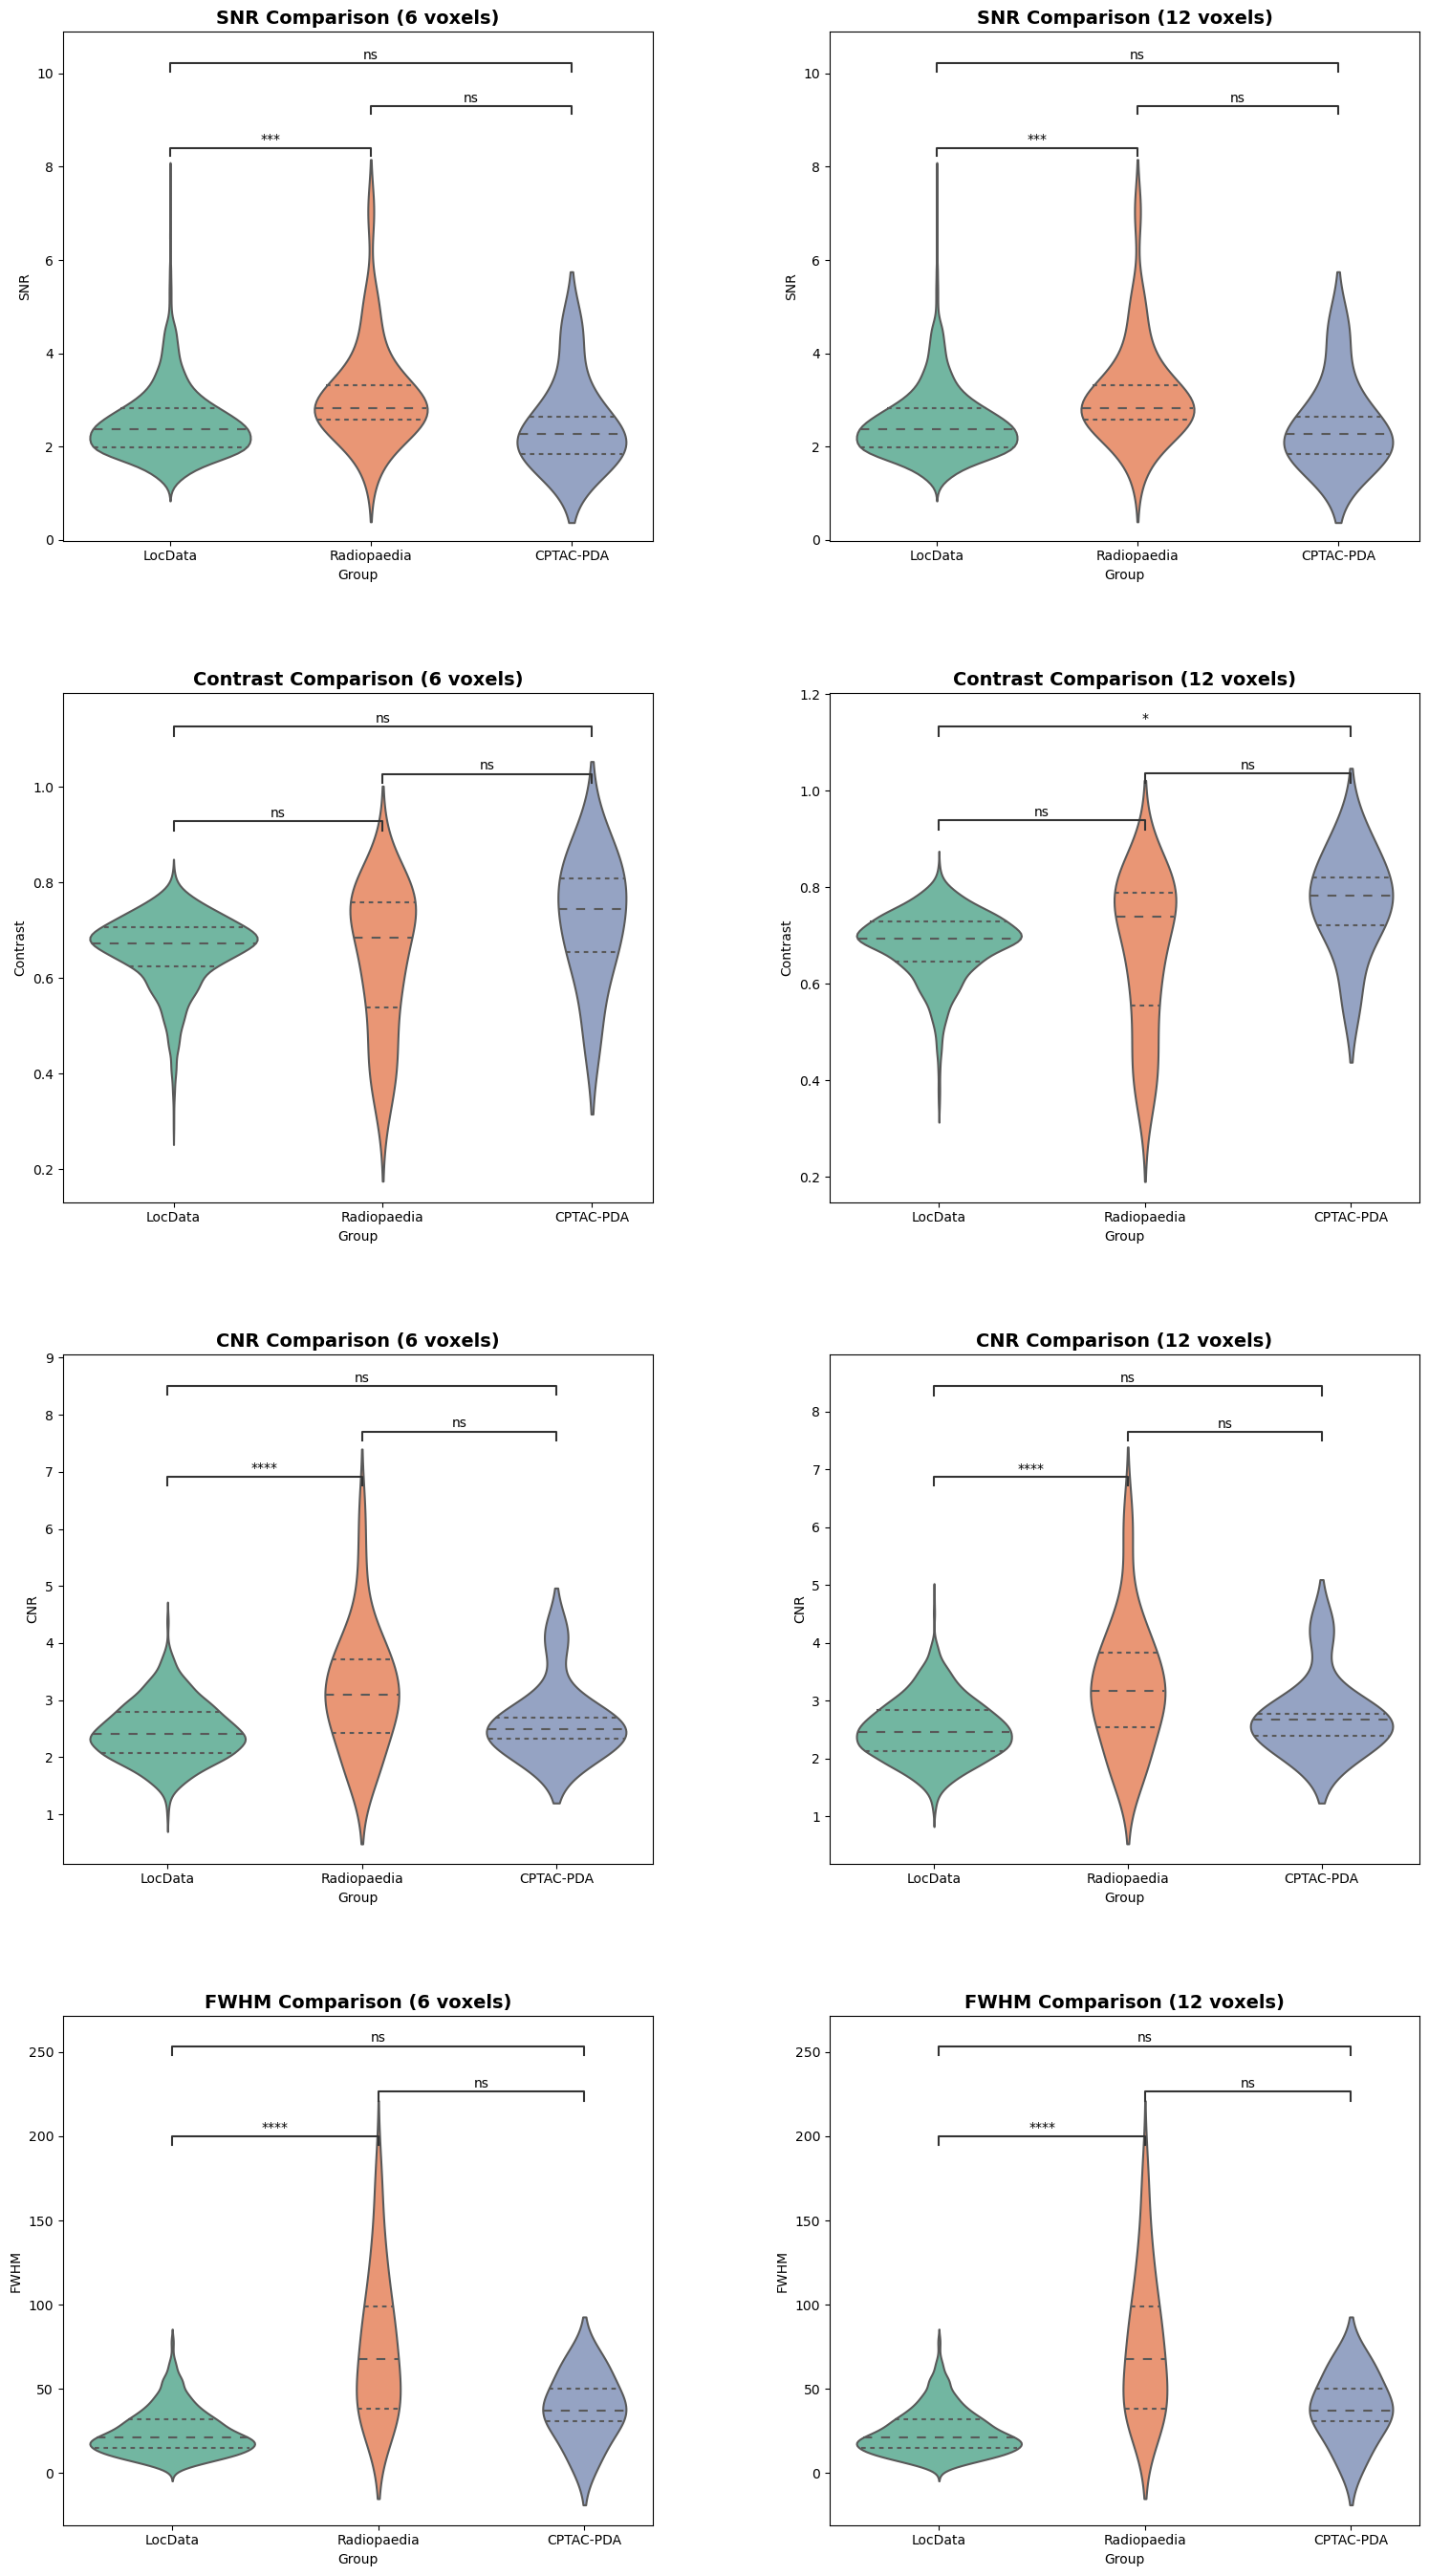

Analysis complete. Combined results saved to /Users/ziling/Desktop/MRCP/results/Violin_Plots_Per_Parameter_LocData_Radiopaedia_CPTAC-PDA.pdf


In [8]:
"""This Python script analyzes MRI data parameters (SNR, Contrast, CNR, FWHM) 
across three groups—`LocData`, `Radiopaedia`, and `CPTAC-PDA`—
for two different voxel sizes (`[6,6,6]` and `[12,12,12]`). 
It uses the Mann-Whitney U test to perform pairwise comparisons 
between the groups and visualizes the data through violin plots, 
which include statistical significance annotations. 
The script outputs the visual comparisons in PDF format, 
providing an easy-to-interpret graphical representation of the differences 
between the groups for each parameter and voxel size.
"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statannot import add_stat_annotation

# Load the data for the three groups (replace with your actual file paths)
group1_path = '/Users/ziling/Desktop/MRCP/results/MRCP_LocData.xlsx'  # Replace with actual file path
group2_path = '/Users/ziling/Desktop/MRCP/results/MRCP_Radiopaedia.xlsx'  # Replace with actual file path
group3_path = '/Users/ziling/Desktop/MRCP/results/MRCP_CPTAC.xlsx'  # Replace with actual file path

# Read the data
group1 = pd.read_excel(group1_path)
group2 = pd.read_excel(group2_path)
group3 = pd.read_excel(group3_path)

# Add a column to identify the group
group1['Group'] = 'LocData'
group2['Group'] = 'Radiopaedia'
group3['Group'] = 'CPTAC-PDA'

# Concatenate the datasets
all_data = pd.concat([group1, group2, group3], ignore_index=True)

# Create a new column for voxel size based on the 'Radi' column
all_data['Voxel Size'] = all_data['Radius'].apply(lambda x: '6 voxels' if '[6, 6, 6]' in x else '12 voxels')

# Set up the figure with 4 rows and 2 columns to display each parameter's comparison for both voxel sizes in a row
plt.figure(figsize=(16, 28))
palette = sns.color_palette("Set2")
pairs = [('LocData', 'Radiopaedia'), ('LocData', 'CPTAC-PDA'), ('Radiopaedia', 'CPTAC-PDA')]

# Define the parameters and their respective row positions for consistent plotting
parameters = ['SNR', 'Contrast', 'CNR', 'FWHM']
titles = ['SNR', 'Contrast', 'CNR', 'FWHM']

for idx, param in enumerate(parameters):
    for voxel_size_idx, voxel_size in enumerate(['6 voxels', '12 voxels']):
        # Filter the data for the current voxel size
        voxel_data = all_data[all_data['Voxel Size'] == voxel_size]

        # Violin plot for each parameter at the given voxel size
        plt.subplot(4, 2, idx * 2 + voxel_size_idx + 1)
        ax = sns.violinplot(x='Group', y=param, data=voxel_data, palette=palette, inner='quartile')
        add_stat_annotation(ax, data=voxel_data, x='Group', y=param,
                            box_pairs=pairs,
                            test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
        plt.title(f'{titles[idx]} Comparison ({voxel_size})', fontsize=14, weight='bold')

# Adjust layout and spacing
plt.tight_layout(pad=4.5)
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Save the combined plot
output_pdf = "/Users/ziling/Desktop/MRCP/results/Violin_Plots_Per_Parameter_LocData_Radiopaedia_CPTAC-PDA.pdf"
plt.savefig(output_pdf)

# Show the plot
plt.show()

print(f"Analysis complete. Combined results saved to {output_pdf}")